In [ ]:
pip install albumentations==0.5.0

Seminar is based on this [article](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/).

In [ ]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader

cudnn.benchmark = True

In [ ]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Dataset already exists on the disk. Skipping download.")
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n


def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)

In [ ]:
os.environ["HOME"]

'/root'

In [ ]:
dataset_directory = os.path.join(os.environ["HOME"], "datasets/oxford-iiit-pet")

In [ ]:
filepath = os.path.join(dataset_directory, "images.tar.gz")
download_url(
    url="https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz", filepath=filepath,
)
extract_archive(filepath)

images.tar.gz: 100%|██████████| 755M/755M [00:38<00:00, 20.8MB/s]


In [ ]:
filepath = os.path.join(dataset_directory, "annotations.tar.gz")
download_url(
    url="https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz", filepath=filepath,
)
extract_archive(filepath)

annotations.tar.gz: 100%|██████████| 18.3M/18.3M [00:03<00:00, 5.69MB/s]


Split files from the dataset into the train and validation sets¶
Some files in the dataset are broken, so we will use only those image files that OpenCV could load correctly. We will use 6000 images for training, 1374 images for validation, and 10 images for testing.

In [ ]:
root_directory = os.path.join(dataset_directory)
images_directory = os.path.join(root_directory, "images")
masks_directory = os.path.join(root_directory, "annotations", "trimaps")

images_filenames = list(sorted(os.listdir(images_directory)))
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]

random.seed(42)
random.shuffle(correct_images_filenames)

train_images_filenames = correct_images_filenames[:6000]
val_images_filenames = correct_images_filenames[6000:-10]
test_images_filenames = images_filenames[-10:]

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))

6000 1374 10


Define a function to preprocess a mask¶
The dataset contains pixel-level trimap segmentation. For each image, there is an associated PNG file with a mask. The size of a mask equals to the size of the related image. Each pixel in a mask image can take one of three values: 1, 2, or 3. 1 means that this pixel of an image belongs to the class pet, 2 - to the class background, 3 - to the class border. Since this example demonstrates a task of binary segmentation (that is assigning one of two classes to each pixel), we will preprocess the mask, so it will contain only two uniques values: 0.0 if a pixel is a background and 1.0 if a pixel is a pet or a border.

In [ ]:
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    return mask

Define a function to visualize images and their labels¶
Let's define a visualization function that will take a list of images' file names, a path to the directory with images, a path to the directory with masks, and an optional argument with predicted masks (we will use this argument later to show predictions of a model).

In [ ]:
def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i, image_filename in enumerate(images_filenames):
        image = cv2.imread(os.path.join(images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(os.path.join(masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,)
        mask = preprocess_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

In [ ]:
display_image_grid(test_images_filenames, images_directory, masks_directory)

Image sizes for training and prediction¶
Often, images that you use for training and inference have different heights and widths and different aspect ratios. That fact brings two challenges to a deep learning pipeline: - PyTorch requires all images in a batch to have the same height and width. - If a neural network is not fully convolutional, you have to use the same width and height for all images during training and inference. Fully convolutional architectures, such as UNet, can work with images of any size.

There are three common ways to deal with those challenges:
1. Resize all images and masks to a fixed size (e.g., 256x256 pixels) during training. After a model predicts a mask with that fixed size during inference, resize the mask to the original image size. This approach is simple, but it has a few drawbacks: - The predicted mask is smaller than the image, and the mask may lose some context and important details of the original image. - This approach may be problematic if images in your dataset have different aspect ratios. For example, suppose you are resizing an image with the size 1024x512 pixels (so an image with an aspect ratio of 2:1) to 256x256 pixels (1:1 aspect ratio). In that case, this transformation will distort the image and may also affect the quality of predictions.
2. If you use a fully convolutional neural network, you can train a model with image crops, but use original images for inference. This option usually provides the best tradeoff between quality, speed of training, and hardware requirements.
3. Do not alter the sizes of images and use source images both for training and inference. With this approach, you won't lose any information. However, original images could be quite large, so they may require a lot of GPU memory. Also, this approach requires more training time to obtain good results.

Some architectures, such as UNet, require that an image's size must be divisible by a downsampling factor of a network (usually 32), so you may also need to pad an image with borders. Albumentations provides a particular transformation for that case.

The following example shows how different types of images look.

In [ ]:
example_image_filename = correct_images_filenames[0]
image = cv2.imread(os.path.join(images_directory, example_image_filename))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

resized_image = A.Resize(256, 256).apply(image, height=256, width=256)
padded_image = F.pad(image, min_height=512, min_width=512)
padded_constant_image = F.pad(image, min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT)
cropped_image = F.center_crop(image, crop_height=256, crop_width=256)

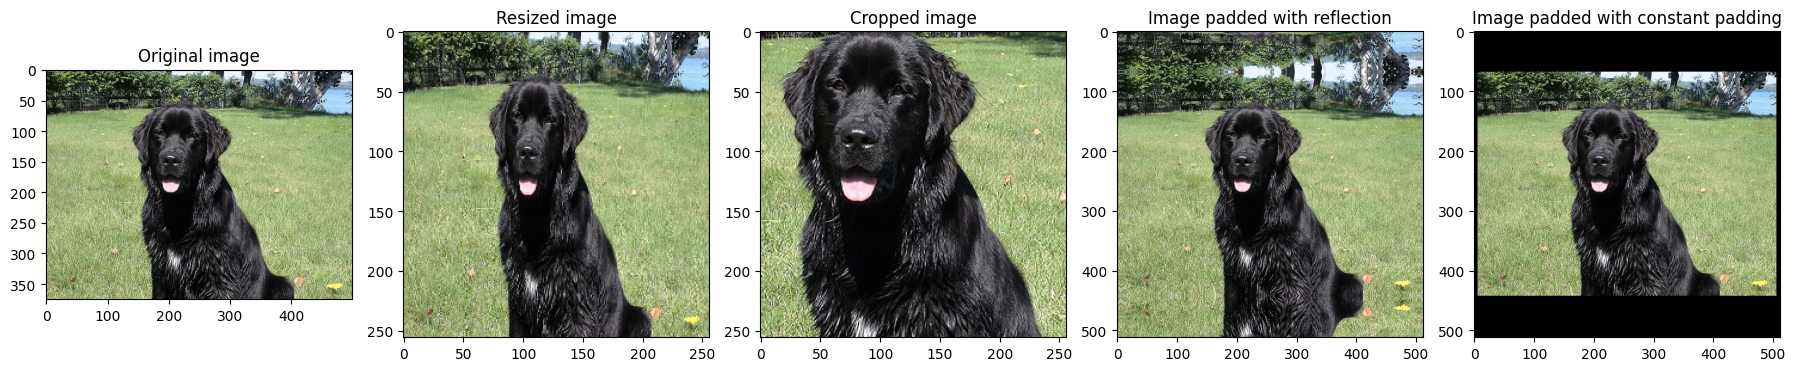

In [ ]:
figure, ax = plt.subplots(nrows=1, ncols=5, figsize=(18, 10))
ax.ravel()[0].imshow(image)
ax.ravel()[0].set_title("Original image")
ax.ravel()[1].imshow(resized_image)
ax.ravel()[1].set_title("Resized image")
ax.ravel()[2].imshow(cropped_image)
ax.ravel()[2].set_title("Cropped image")
ax.ravel()[3].imshow(padded_image)
ax.ravel()[3].set_title("Image padded with reflection")
ax.ravel()[4].imshow(padded_constant_image)
ax.ravel()[4].set_title("Image padded with constant padding")
plt.tight_layout()
plt.show()

Approach 1. Resize all images and masks to a fixed size (e.g., 256x256 pixels).¶
Define a PyTorch dataset class¶
Next, we define a PyTorch dataset. If you are new to PyTorch datasets, please refer to this tutorial - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html.

__init__ will receive an optional transform argument. It is a transformation function of the Albumentations augmentation pipeline. Then in __getitem__, the Dataset class will use that function to augment an image and a mask and return their augmented versions.

In [ ]:
class OxfordPetDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,
        )
        mask = preprocess_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask

Next, we create augmentation pipelines for the training and validation datasets. Note that we use A.Resize(256, 256) to resize input images and masks to the size 256x256 pixels.

In [ ]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = OxfordPetDataset(train_images_filenames, images_directory, masks_directory, transform=train_transform,)

val_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)
val_dataset = OxfordPetDataset(val_images_filenames, images_directory, masks_directory, transform=val_transform,)

Let's define a function that takes a dataset and visualizes different augmentations applied to the same image and the associated mask.

In [ ]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

In [ ]:
random.seed(42)
visualize_augmentations(train_dataset, idx=55)

Define helpers for training¶
MetricMonitor helps to track metrics such as accuracy or loss during training and validation.

In [ ]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [ ]:
from torchvision import models
fcn = models.segmentation.fcn_resnet50(pretrained=True).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:01<00:00, 115MB/s]


In [ ]:
fcn(torch.randn(1, 3, 256, 256))['out'].shape

torch.Size([1, 21, 256, 256])

In [ ]:
fcn(torch.randn(1, 3, 512, 512))['out'].shape

torch.Size([1, 21, 512, 512])

In [ ]:
fcn(torch.randn(1, 3, 16, 16))['out'].shape

torch.Size([1, 21, 16, 16])

In [ ]:
fcn.classifier[4]

Conv2d(512, 21, kernel_size=(1, 1), stride=(1, 1))

In [ ]:
fcn

Define functions for training and validation¶

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        output = model(images)['out'].squeeze(1)
        loss = criterion(output, target)
        metric_monitor.update("Loss", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [ ]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images)['out'].squeeze(1)
            loss = criterion(output, target)
            metric_monitor.update("Loss", loss.item())
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [ ]:
def create_model(params):
    model = models.segmentation.fcn_resnet50(pretrained=True)
    model = model.to(params["device"])
    for param in model.parameters():
        param.requires_grad = False
    for param in model.classifier.parameters():
        param.requires_grad = True

    model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1), device=params['device'])
    return model

In [ ]:
def train_and_validate(model, train_dataset, val_dataset, params):
    train_loader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        shuffle=True,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=params["batch_size"],
        shuffle=False,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    criterion = nn.BCEWithLogitsLoss().to(params["device"])
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
    for epoch in range(1, params["epochs"] + 1):
        train(train_loader, model, criterion, optimizer, epoch, params)
        validate(val_loader, model, criterion, epoch, params)
    return model

In [ ]:
def predict(model, params, test_dataset, batch_size):
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=params["num_workers"], pin_memory=True,
    )
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, (original_heights, original_widths) in test_loader:
            images = images.to(params["device"], non_blocking=True)
            output = model(images)['out']
            probabilities = torch.sigmoid(output.squeeze(1))
            predicted_masks = (probabilities >= 0.5).float() * 1
            predicted_masks = predicted_masks.cpu().numpy()
            for predicted_mask, original_height, original_width in zip(
                predicted_masks, original_heights.numpy(), original_widths.numpy()
            ):
                predictions.append((predicted_mask, original_height, original_width))
    return predictions

Define training parameters¶
Here we define a few training parameters such as model architecture, learning rate, batch size, epochs, etc.

In [ ]:
params = {
    "model": "UNet11",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 16,
    "num_workers": 4,
    "epochs": 10,
}

Train a model

In [ ]:
model = create_model(params)
model = train_and_validate(model, train_dataset, val_dataset, params)

Predict labels for images and visualize those predictions¶
Now we have a trained model, so let's try to predict masks for some images. Note that the __getitem__ method returns not only an image but also the original height and width of an image. We will use those values to resize a predicted mask from the size of 256x256 pixels to the original image's size.

In [ ]:
class OxfordPetInferenceDataset(Dataset):
    def __init__(self, images_filenames, images_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_size = tuple(image.shape[:2])
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, original_size

In [ ]:
test_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)
test_dataset = OxfordPetInferenceDataset(test_images_filenames, images_directory, transform=test_transform,)

In [ ]:
predictions = predict(model, params, test_dataset, batch_size=16)

Next, we will resize the predicted masks with the size of 256x256 pixels to the original images' size.



In [ ]:
predicted_masks = []
for predicted_256x256_mask, original_height, original_width in predictions:
    full_sized_mask = F.resize(
        predicted_256x256_mask, height=original_height, width=original_width, interpolation=cv2.INTER_NEAREST
    )
    predicted_masks.append(full_sized_mask)

In [ ]:
display_image_grid(test_images_filenames, images_directory, masks_directory, predicted_masks=predicted_masks)

# No augmentation

In [ ]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        # A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        # A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        # A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = OxfordPetDataset(train_images_filenames, images_directory, masks_directory, transform=train_transform,)

In [ ]:
params = {
    "model": "UNet11",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 16,
    "num_workers": 4,
    "epochs": 10,
}

In [ ]:
model = create_model(params)
model = train_and_validate(model, train_dataset, val_dataset, params)

# More experiments here: pad, no resize, other augmentations

In [ ]:
# YOUR CODE HERE

# Some metrics and losses

In [ ]:
def calc_iou(prediction, ground_truth):
    # YOUR CODE HERE
    n_images = len(prediction)
    intersection, union = [], []
    for i in range(n_images):
        intersection += [np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()]
        union += [np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()]
    return ((np.array(intersection) + 1e-7) / (np.array(union) + 1e-7)).sum()

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-4):
        super().__init__()
        self.smooth = smooth
    def forward(self, preds, targets):
        # YOUR CODE HERE
        intersection = (preds * targets).sum()
        union = preds.sum() + targets.sum()
        dice = (2 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice

# Your own Unet

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1):
        super().__init__()
        # YOUR CODE HERE
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
    def forward(self, x):
        # YOUR CODE HERE
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # YOUR CODE HERE
        self.dconv = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        # YOUR CODE HERE
        return self.dconv(x)

class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        # YOUR CODE HERE
        # self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        # YOUR CODE HERE
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], dim=1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_classes=2, in_channels=3):
        super().__init__()
        # YOUR CODE HERE
        self.pooling = nn.MaxPool2d(2)
        self.inp = DoubleConvBlock(in_channels, 64)
        self.conv1 = DoubleConvBlock(64, 128)
        self.conv2 = DoubleConvBlock(128, 256)
        self.conv3 = DoubleConvBlock(256, 512)
        self.conv4 = DoubleConvBlock(512, 1024)

        self.upconv1 = UpConvBlock(1024+512, 512)
        self.upconv2 = UpConvBlock(512+256, 256)
        self.upconv3 = UpConvBlock(256+128, 128)
        self.upconv4 = UpConvBlock(128+64, 64)

        self.out = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=1)
        )
    def forward(self, x):
        # YOUR CODE HERE
        x1 = self.inp(x)
        x2 = self.conv1(x1)
        x2 = self.pooling(x2)
        x3 = self.conv2(x2)
        x3 = self.pooling(x3)
        x4 = self.conv3(x3)
        x4 = self.pooling(x4)
        x5 = self.conv4(x4)
        x5 = self.pooling(x5)

        x = self.upconv1(x5, x4)
        x = self.upconv2(x, x3)
        x = self.upconv3(x, x2)
        x = self.upconv4(x, x1)
        x = self.out(x)
        return {'out': x}

In [ ]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = OxfordPetDataset(train_images_filenames, images_directory, masks_directory, transform=train_transform,)

In [ ]:
model = UNet()
model(torch.randn(1, 3, 256, 256))['out'].shape

torch.Size([1, 1, 256, 256])

In [ ]:
model(torch.randn(1, 3, 256+128, 256+128))['out'].shape

torch.Size([1, 1, 384, 384])

In [ ]:
params = {
    "model": "UNet11",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 4,
    "num_workers": 4,
    "epochs": 10,
}

model = UNet().to('cuda')

model = train_and_validate(model, train_dataset, val_dataset, params)